<a href="https://colab.research.google.com/github/Prajwalsrinvas/advent_of_haystack_2024/blob/main/Day_3_Multi_Query_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 3

In this challenge, you must help Elf David build a system to answer questions over BBC news dataset. However, to increase recall, your system should be able to generate questions similar to the ones asked.

For instance, if Santa asks, `"How are cybersecurity threats evolving with new technologies?"` the system should be able to generate similar questions like:

- `"What impact do emerging technologies like AI and IoT have on the landscape of cybersecurity threats?"`
- `"How are organizations adapting their cybersecurity strategies in response to the evolution of threats driven by technological advancements?"`
- `"In what ways are cybercriminals leveraging new technologies to enhance their attack methods and tactics?"`

All these questions are similar to the original question, but they are not the same. The idea is that by generating similar questions, you can increase the system's recall, as the system will be able to retrieve more documents that could contain the answer to the original question.
For that, you will use a large language model (LLM) to generate alternative similar questions based on the original question.
Each of these similar questions will query a document store with news articles; all the documents retrieved by each similar question will be used to compose an answer to the original question.


### Components to use:

- [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore): to store the news articles.
- [`InMemoryEmbeddingRetriever`](https://docs.haystack.deepset.ai/docs/inmemoryembeddingretriever): to retrieve the documents from the document store.
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator): to instantiate the LLM to generate similar questions and compose an answer to the original question.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder): to build the prompts to query the LLM
- [`AnswerBuilder`](https://docs.haystack.deepset.ai/docs/answerbuilder): (optional) to build the answers to the original question.
- [`SentenceTransformersTextEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder): to embed the questions
- [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder): to embed the news articles
- [`DocumentJoiner`](https://docs.haystack.deepset.ai/docs/documentjoiner): to join the documents retrieved by similar query questions

### Your task is to build two custom components:

- `MultiQueryGenerator`: a custom component that uses an LLM to generate similar questions based on the original question.
- `MultiQueryHandler`: a custom component that queries the document store with a set of query questions and collects all the documents

**Note:** Feel free to change the models in this challenge and use different model providers.

### 1) Installation

Install packages and the BBC news dataset

In [1]:
!pip install -q haystack-ai
!pip install -q "sentence-transformers>=3.0.0"
!pip install -q lazy_imports
!pip install -q --upgrade openai # not to get the OpenAI proxies error: https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2
!wget https://raw.githubusercontent.com/amankharwal/Website-data/master/bbc-news-data.csv

--2024-12-29 19:12:32--  https://raw.githubusercontent.com/amankharwal/Website-data/master/bbc-news-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5080260 (4.8M) [text/plain]
Saving to: ‘bbc-news-data.csv.1’

bbc-news-data.csv.1 100%[===================>]   4.84M  --.-KB/s    in 0.09s   

2024-12-29 19:12:32 (52.4 MB/s) - ‘bbc-news-data.csv.1’ saved [5080260/5080260]



In [2]:
!head -2 bbc-news-data.csv

category	filename	title	content
business	001.txt	Ad sales boost Time Warner profit	 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarn

In [3]:
!wc -l bbc-news-data.csv

2225 bbc-news-data.csv


In [4]:
import logging

logging.basicConfig(
    format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING
)
logging.getLogger("haystack").setLevel(logging.DEBUG)

### 2) Enter API keys for LLM
If you want to use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [5]:
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


### 3) Parse the news dataset and index it

In [6]:
import csv
from typing import List

from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter
from haystack import Pipeline


def read_documents(file: str) -> List[Document]:
    with open(file, "r") as file:
        reader = csv.reader(file, delimiter="\t")
        next(reader, None)  # skip the headers
        docs = []
        for row in reader:
            category = row[0].strip()
            title = row[2].strip()
            text = row[3].strip()
            docs.append(
                Document(content=text, meta={"category": category, "title": title})
            )

    return docs


embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
doc_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    "embedder", SentenceTransformersDocumentEmbedder(model=embedding_model)
)
indexing_pipeline.add_component(
    "writer", DocumentWriter(doc_store, policy=DuplicatePolicy.OVERWRITE)
)
indexing_pipeline.connect("embedder", "writer")

documents = read_documents("bbc-news-data.csv")
indexing_pipeline.run({"embedder": {"documents": documents}})

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.embedders.azure_document_embedder.AzureOpenAIDocumentEmbedder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.embedders.azure_document_embedder.AzureOpenAIDocumentEmbedder'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.embedders.azure_text_embedder.AzureOpenAITextEmbedder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.embedders.azure_text_embedder.AzureOpenAITextEmbedder'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.embedders.hugging_face_api_document_embedder.HuggingFaceAPIDocumentEmbedder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.embedders.hugging_face_api_document_embedder.HuggingFaceAPIDocumentEmbedder'>
DEBUG:haystack.core.component.component:Registering 

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

INFO:haystack.core.pipeline.pipeline:Running component writer


{'writer': {'documents_written': 2225}}

### 4) Define a custom component `MultiQueryGenerator`
This custom component will generate `n` alternatives to each query using a [Generator](https://docs.haystack.deepset.ai/docs/generators) and a [PromptBuilder](https://docs.haystack.deepset.ai/docs/promptbuilder).

We have prepared a template for this component, feel free to change it as you wish.

**Hint:** You can start with this prompt template 👇  
```python
template =
"""
You are an AI language model assistant. Your task is to generate {{n_variations}} different versions of the
given user question by expanding the meaning of it.
By generating multiple perspectives on the user question, you will help gather diverse information that will be useful to answer the user question in more comprehensive manner.
The generated questions should be concise. Do not just rephrase the question, think about the other topics that are relevent to the user question.

Provide these alternative questions separated by newlines.
Original question: {{question}}
Alternative: questions:
"""
```
**Hint** If you're using OpenAI models, feel free to use [`n` parameter](https://platform.openai.com/docs/api-reference/chat/create#chat-create-n) of the API and update the prompt accordingly

In [7]:
from haystack import component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator


@component
class MultiQueryGenerator:
    def __init__(self):
        # You need to define a Generator and a PromptBuilder to pass to that generator
        # The template of the PromptBuilder will have two variables:
        #    - 'query' a string,
        #    - 'n_variations' the number of variations of the query string to generate
        template = """You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.
Your goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.
The question should be concise and explore related topics, not just rephrase the original.
Return only the alternative question with no additional text.

Original: {{query}}"""
        self.builder = PromptBuilder(template=template)
        self.client = OpenAIGenerator(model="gpt-4o")


    @component.output_types(queries=List[str])
    def run(self, query: str, n_variations: int = 3):
        # You need build a prompt filling in the variables 'query' and 'n_variations'
        # This prompt is then pased to a generator, and you need to collect the result
        # You should return a List[str] with the original query, plus, the 'n_variations' generated by the LLM
        prompt=self.builder.run(query=query)['prompt']
        print(f'{prompt=}')
        response=self.client.run(prompt=prompt,generation_kwargs={'n':n_variations})
        queries = [query] + response['replies']
        print(f'{queries=}')
        return {"queries": queries}

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.builders.answer_builder.AnswerBuilder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.builders.answer_builder.AnswerBuilder'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.builders.chat_prompt_builder.ChatPromptBuilder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.builders.chat_prompt_builder.ChatPromptBuilder'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.builders.prompt_builder.PromptBuilder'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.builders.prompt_builder.PromptBuilder'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.generators.openai.OpenAIGenerator'> as a component
DEBUG:haystack.core.component.component:Registered Componen

In [8]:
test=MultiQueryGenerator()
queries=test.run(query='What is popular in the music industry today?')['queries']

prompt='You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.\nYour goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.\nThe question should be concise and explore related topics, not just rephrase the original.\nReturn only the alternative question with no additional text.\n\nOriginal: What is popular in the music industry today?'
queries=['What is popular in the music industry today?', 'How have recent technological advancements impacted trends in the music industry?', 'How have recent technological advancements influenced current trends and artist success in the music industry?', 'How are current technological advancements influencing trends in the music industry?']


### 5) Define the custom component `MultiQueryHandler`

This component will query the document store with multiple questions and collect all the retrieved documents

In [9]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers import InMemoryEmbeddingRetriever

@component
class MultiQueryHandler:
    def __init__(self, document_store, embedding_model: str):
        # Initialize your SentenceTransformersTextEmbedder and InMemoryEmbeddingRetriever here
        # Ensure that the embedding model used for indexing is the same one used for querying in SentenceTransformersTextEmbedder
        self.text_embedder = SentenceTransformersTextEmbedder(model=embedding_model)
        self.text_embedder.warm_up()
        self.retriever=InMemoryEmbeddingRetriever(document_store=document_store)

    @component.output_types(answers=List[Document])
    def run(self, queries: List[str], top_k: int = 3):
        # You need to initialize an embedder to embed each query in `queries`
        # Each query will be used to retrieve a List[Document] from the document_store
        # You then need to pack all those into a single List[Document] and return it
        documents=[]
        for query in queries:
          query_embedding=self.text_embedder.run(query)['embedding']
          relevant_docs=self.retriever.run(query_embedding=query_embedding,top_k=top_k)['documents']
          documents.extend(relevant_docs)

        return {"answers": documents}

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.retrievers.filter_retriever.FilterRetriever'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.retrievers.filter_retriever.FilterRetriever'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.retrievers.in_memory.bm25_retriever.InMemoryBM25Retriever'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.retrievers.in_memory.bm25_retriever.InMemoryBM25Retriever'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.retrievers.sente

In [10]:
test=MultiQueryHandler(document_store=doc_store,embedding_model=embedding_model)
test.run(queries=queries)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'answers': [Document(id=bc89bdbbd9cf891655ba355adca8e42b0fa4435e83862b9a4e80ca3aaa2fc810, content: 'The German music business - the third largest in the world - is "in the state of a zombie" because i...', meta: {'category': 'entertainment', 'title': "German music in a 'zombie' state"}, score: 0.48212397599404133),
  Document(id=4f2873bd783817f2121d651babf1ab0bea87fa12c798321dd0e4c28efc1be35a, content: 'Musicians are embracing the internet as a way of reaching new fans and selling more music, a survey ...', meta: {'category': 'tech', 'title': "Musicians 'upbeat' about the net"}, score: 0.46013809756659924),
  Document(id=063f8f3dc30bcd4120babdbeb3770394c882cf04751aa3fd9898324d5b32f5fa, content: 'UK consumers are the biggest music buyers in the world, according to new figures released on Tuesday...', meta: {'category': 'entertainment', 'title': "UK 'world's biggest music buyer'"}, score: 0.4184091895893629),
  Document(id=bc89bdbbd9cf891655ba355adca8e42b0fa4435e83862b9a4e80ca3aaa2fc810

### 6) Define the RAG Pipeline with Multi-Query Retrieval

Given a question, this RAG pipeline will generate multiple similar questions, query the document store and collect all the retrieved documents

In [11]:
from haystack import component, Pipeline, Document
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.embedders import (
    SentenceTransformersTextEmbedder,
    SentenceTransformersDocumentEmbedder,
)
from haystack.components.generators import OpenAIGenerator
from haystack.components.joiners import DocumentJoiner
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

template = """
You have to answer the following question based on the given context information only.
If the context is empty or just a '\\n' answer with None, example: "None".

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

pipeline = Pipeline()

# add components
pipeline.add_component("multi_query_generator", MultiQueryGenerator())
pipeline.add_component(
    "multi_query_handler",
    MultiQueryHandler(document_store=doc_store, embedding_model=embedding_model),
)
pipeline.add_component("reranker", DocumentJoiner(join_mode="reciprocal_rank_fusion"))
pipeline.add_component("prompt_builder", PromptBuilder(template=template))
pipeline.add_component("llm", OpenAIGenerator())
pipeline.add_component("answer_builder", AnswerBuilder())

# connect components
pipeline.connect("multi_query_generator.queries", "multi_query_handler.queries")
pipeline.connect("multi_query_handler.answers", "reranker.documents")
pipeline.connect("reranker", "prompt_builder.documents")
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm.replies", "answer_builder.replies")
pipeline.connect("llm.meta", "answer_builder.meta")

DEBUG:haystack.core.component.component:Registering <class 'haystack.components.joiners.answer_joiner.AnswerJoiner'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.joiners.answer_joiner.AnswerJoiner'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.joiners.branch.BranchJoiner'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.joiners.branch.BranchJoiner'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.joiners.document_joiner.DocumentJoiner'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.joiners.document_joiner.DocumentJoiner'>
DEBUG:haystack.core.component.component:Registering <class 'haystack.components.joiners.string_joiner.StringJoiner'> as a component
DEBUG:haystack.core.component.component:Registered Component <class 'haystack.components.joiners.str

🚅 Components
  - multi_query_generator: MultiQueryGenerator
  - multi_query_handler: MultiQueryHandler
  - reranker: DocumentJoiner
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - multi_query_generator.queries -> multi_query_handler.queries (List[str])
  - multi_query_handler.answers -> reranker.documents (List[Document])
  - reranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])
  - llm.meta -> answer_builder.meta (List[Dict[str, Any]])

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

multi_query_generator["<b>multi_query_generator</b><br><small><i>MultiQueryGenerator<br><br>Optional inputs:<ul style='text-align:left;'><li>n_variations (int)</li></ul></i></small>"]:::component -- "queries -> queries<br><small><i>List[str]</i></small>" --> multi_query_handler["<b>multi_query_handler</b><br><small><i>MultiQueryHandler<br><br>Optional inputs:<ul style='text-align:left;'><li>top_k (int)</li></ul></i></small>"]:::component
multi_query_handler["<b>multi_query_handler</b><br><small><i>MultiQueryHandler<br><br>Optional inputs:<ul style='text-align:left;'><li>top_k (int)</li></ul></i></small>"]:::component -- "answers -> documents<br><small><i>List[Document]</i></small>" --> reranker["<b>reranker</b><br><small><i>DocumentJoiner<br><br>Optional inputs:<ul style='text-align:left;'><li>documents (List[Document])</li><li>top_k (Optional[int])</li></ul></i></small>"]:::component
re

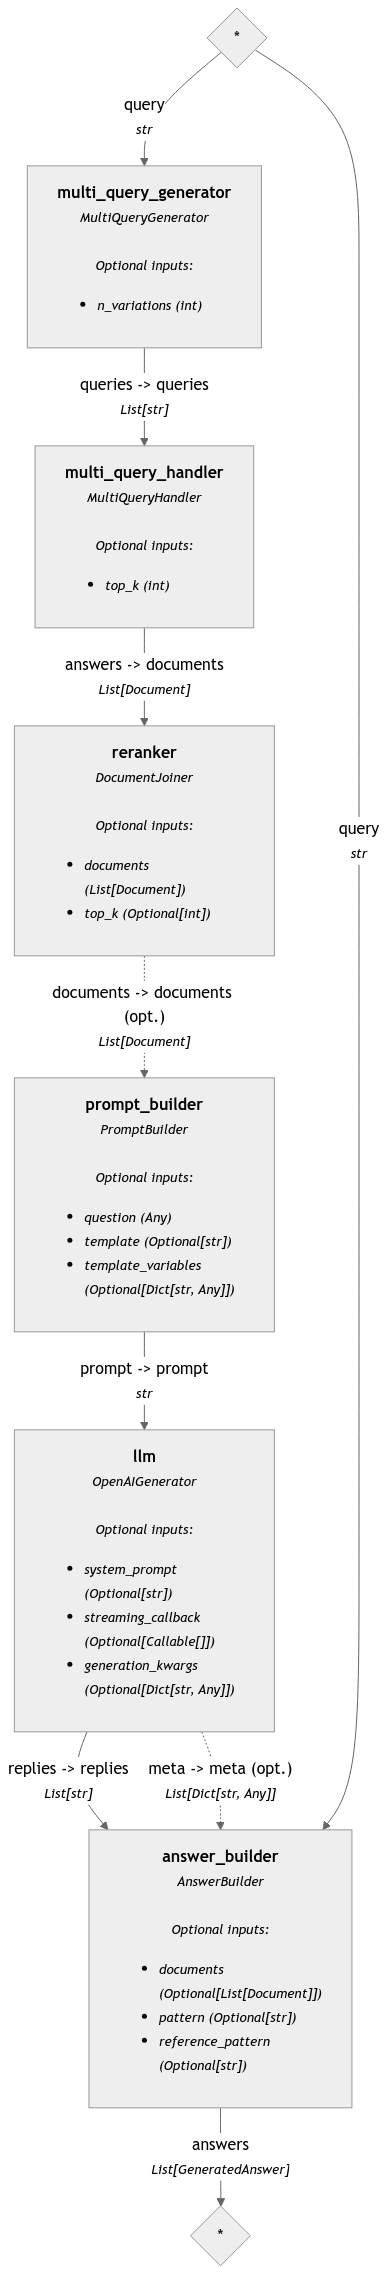

In [12]:
pipeline.show()

In [13]:
from IPython.display import display, Markdown


In [14]:
questions=["Can you give me some suggestions do you have for Christmas presents? Please provide a variety of options.",
"What is popular in the music industry today?",
"How are cybersecurity threats evolving with new technologies?",
"What does UK do to prevent piracy in music industry?"]

n_variations = 3
top_k = 3

for question in questions:
  result = pipeline.run(
      {'multi_query_generator':{'query':question, 'n_variations':n_variations},
      'multi_query_handler':{'top_k':top_k},
      'prompt_builder': {'template_variables': {'question':question}},
      'answer_builder':{'query':question}
      }, include_outputs_from={"multi_query_generator"}
  )
  print("\n\nQuestions:\n")
  for q in result["multi_query_generator"]["queries"]:
      display(Markdown(q))
  print("\n\nAnswer:\n")
  display(Markdown(result["answer_builder"]["answers"][0].data))
  print('-'*100)
  print()

INFO:haystack.core.pipeline.pipeline:Running component multi_query_generator


prompt='You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.\nYour goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.\nThe question should be concise and explore related topics, not just rephrase the original.\nReturn only the alternative question with no additional text.\n\nOriginal: Can you give me some suggestions do you have for Christmas presents? Please provide a variety of options.'


INFO:haystack.core.pipeline.pipeline:Running component multi_query_handler


queries=['Can you give me some suggestions do you have for Christmas presents? Please provide a variety of options.', 'What are some creative Christmas gift ideas that cater to different age groups and interests?', 'What are some unique and thoughtful Christmas gift ideas that cater to different age groups and interests?', 'What unique or personalized gift ideas can you recommend for different age groups and interests during the Christmas season?']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:haystack.core.pipeline.pipeline:Running component reranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component llm
INFO:haystack.core.pipeline.pipeline:Running component answer_builder




Questions:



Can you give me some suggestions do you have for Christmas presents? Please provide a variety of options.

What are some creative Christmas gift ideas that cater to different age groups and interests?

What are some unique and thoughtful Christmas gift ideas that cater to different age groups and interests?

What unique or personalized gift ideas can you recommend for different age groups and interests during the Christmas season?



Answer:



1. **Child Trust Fund Contribution**: A financial gift that can help children save for their future, especially university costs.

2. **Higher Rate Children's Deposit Account**: Invest gifts in accounts that pay higher interest rates, like the Ladybird account or Alliance & Leicester FirstSaver.

3. **Premium Bonds**: A unique gift offering the chance to win prizes, sold in multiples of £10.

4. **Stock Market Investments**: Consider investing in a unit trust or an Exchange Traded Fund (ETF) for potential long-term growth.

5. **Books**: Consider popular children's books like "Fergus Crane" or "Spilled Water" for young readers.

6. **Gadgets and Electronics**: Items like digital cameras or LCD televisions, which have become hot gift items this year.

7. **Online Auction Finds**: Rare toys like Robosapiens or the slimline PlayStation 2 available through sites like eBay.

8. **Gift Cards**: Allow recipients to choose their own gifts while ensuring they get something they truly want.

9. **Art and Craft Supplies**: Encourage creativity in children with a variety of art supplies or craft kits.

10. **Experiential Gifts**: Tickets to events, museums, or amusement parks that provide memorable experiences rather than physical items.

INFO:haystack.core.pipeline.pipeline:Running component multi_query_generator


----------------------------------------------------------------------------------------------------

prompt='You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.\nYour goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.\nThe question should be concise and explore related topics, not just rephrase the original.\nReturn only the alternative question with no additional text.\n\nOriginal: What is popular in the music industry today?'


INFO:haystack.core.pipeline.pipeline:Running component multi_query_handler


queries=['What is popular in the music industry today?', 'How are current social trends and technological advancements influencing music consumption and production today?', 'How have recent technological advancements influenced current trends in the music industry?', 'How are current trends in the music industry shaping the way artists promote their music?']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:haystack.core.pipeline.pipeline:Running component reranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component llm
INFO:haystack.core.pipeline.pipeline:Running component answer_builder




Questions:



What is popular in the music industry today?

How are current social trends and technological advancements influencing music consumption and production today?

How have recent technological advancements influenced current trends in the music industry?

How are current trends in the music industry shaping the way artists promote their music?



Answer:



Musicians are embracing the internet as a way of reaching new fans and selling more music. They see the internet as a valuable tool for promotion, advertising, and selling their music directly to fans, rather than just viewing it as a threat.

INFO:haystack.core.pipeline.pipeline:Running component multi_query_generator


----------------------------------------------------------------------------------------------------

prompt='You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.\nYour goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.\nThe question should be concise and explore related topics, not just rephrase the original.\nReturn only the alternative question with no additional text.\n\nOriginal: How are cybersecurity threats evolving with new technologies?'


INFO:haystack.core.pipeline.pipeline:Running component multi_query_handler


queries=['How are cybersecurity threats evolving with new technologies?', 'What role do emerging technologies play in shaping the nature and response to cybersecurity threats?', 'What impact do emerging technologies have on the strategies and tactics used in cybersecurity defense?', 'What roles do emerging technologies play in transforming the landscape of cybersecurity challenges and defense mechanisms?']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:haystack.core.pipeline.pipeline:Running component reranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component llm
INFO:haystack.core.pipeline.pipeline:Running component answer_builder




Questions:



How are cybersecurity threats evolving with new technologies?

What role do emerging technologies play in shaping the nature and response to cybersecurity threats?

What impact do emerging technologies have on the strategies and tactics used in cybersecurity defense?

What roles do emerging technologies play in transforming the landscape of cybersecurity challenges and defense mechanisms?



Answer:



Cybersecurity threats are evolving with new technologies as criminals increasingly use advanced technical tricks to craft malicious programs for direct criminal ends, moving away from traditional viruses to more complex forms like spyware and phishing attacks. The shift reflects a growing focus on financial gain, with organized crime gangs leveraging technology to exploit vulnerabilities in systems and trick users into unwittingly compromising their data or machines. Additionally, the rise of bot nets and remote-controlled computers indicates a more sophisticated approach, allowing for large-scale attacks while diminishing the traditional individual hacker profile. As a result, the categorization of threats has become more complex and challenging to manage, necessitating updates in defensive strategies for both individuals and organizations.

INFO:haystack.core.pipeline.pipeline:Running component multi_query_generator


----------------------------------------------------------------------------------------------------

prompt='You are an AI language model assistant. Your task is to generate one alternative version of the given question by expanding its meaning.\nYour goal is to explore a different but relevant perspective that will help gather comprehensive information about the topic.\nThe question should be concise and explore related topics, not just rephrase the original.\nReturn only the alternative question with no additional text.\n\nOriginal: What does UK do to prevent piracy in music industry?'


INFO:haystack.core.pipeline.pipeline:Running component multi_query_handler


queries=['What does UK do to prevent piracy in music industry?', 'How does the UK music industry collaborate with international organizations to address music piracy on a global scale?', 'How does the UK address and mitigate the impact of digital piracy on its creative industries, including music?', 'How does the UK encourage legal music consumption and combat digital piracy?']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:haystack.core.pipeline.pipeline:Running component reranker
INFO:haystack.core.pipeline.pipeline:Running component prompt_builder
INFO:haystack.core.pipeline.pipeline:Running component llm
INFO:haystack.core.pipeline.pipeline:Running component answer_builder




Questions:



What does UK do to prevent piracy in music industry?

How does the UK music industry collaborate with international organizations to address music piracy on a global scale?

How does the UK address and mitigate the impact of digital piracy on its creative industries, including music?

How does the UK encourage legal music consumption and combat digital piracy?



Answer:



The UK is implementing lessons on music piracy and copyright issues for secondary school pupils, aimed at educating them about the importance of copyright and its role in protecting creativity. The initiative is supported by British Music Rights (BMR) and aims to raise awareness of different careers in the music industry, particularly in the digital age. Additionally, BMR's Respect the Value of Music campaign is part of the effort to combat music piracy. Schools have requested educational resources to help teach these issues, and prominent musicians have endorsed the scheme to protect young people entering the music industry.

----------------------------------------------------------------------------------------------------

